In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Description and Problem Statement

The data provided contains two files similar in content. The train dataset contains columns id, keyword, location, text and target. Text is the content pulled from Twitter which here is used as a database of sorts. Target is the label assigned manually following a review of whether the text in the associated row is considered a notice of a disaster (1) or a non disaster (0).

The goal is to train a model that can reasonably predict whether a tweet is related to a disaster or not. The measure of effectiveness of the model will be the F score. In additon to this, accuracy is calculated to reinforce the F-score and provide a more comprehensive measure to people not as familiar with statistics. 

### Initiation

Read in the data and review basic properties of it. 

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
print("TensorFlow version:", tf.__version__)

2024-06-17 21:17:54.803151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 21:17:54.803288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 21:17:54.984950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0


In [4]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


We can see from the above the "stats" of each data set are similar which should support the model generalizing well to the unseen data in the test set. Additionally, the test set is not labeled which was expected based on the description of the data set in the compeition home page. 

### EDA

The next step is to complete exploratory data analysis on the data set to better understand the underlying data and develop a better plan for cleaning the dataset. 

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji

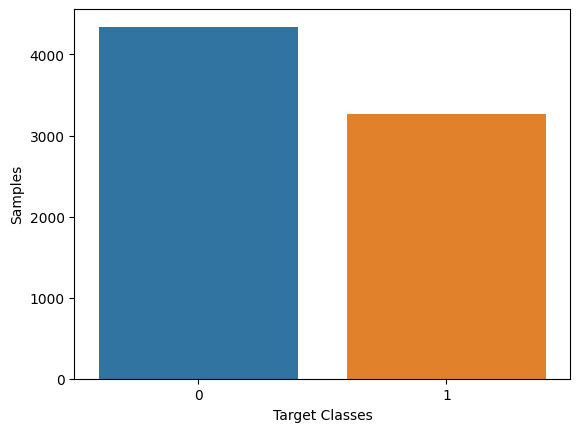

In [8]:
x = df_train['target'].value_counts().index
y = df_train['target'].value_counts().values
sns.barplot(x=x, y=y)

plt.xlabel('Target Classes')
plt.ylabel('Samples')

plt.show()


The distribution of classes is acceptable and no method will be taken to even the classes out. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


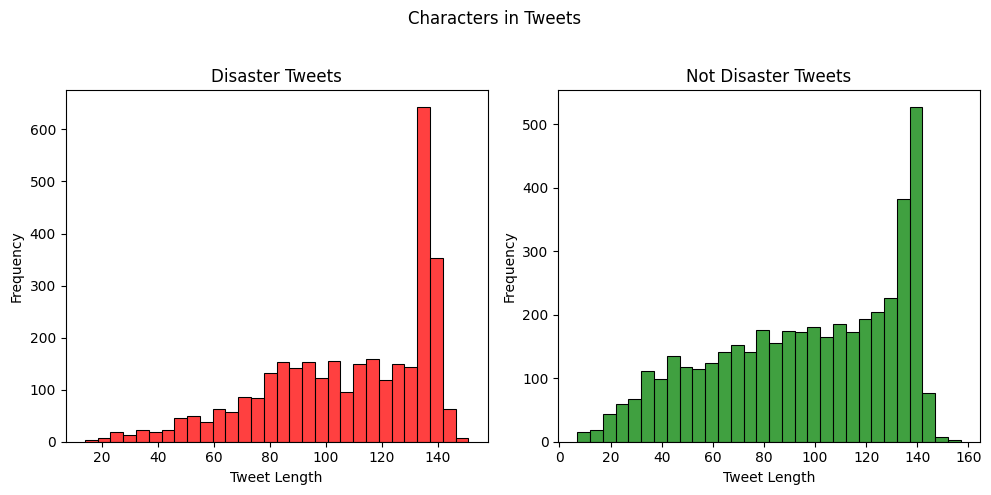

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Length of disaster tweets
disaster_tweet_len = df_train[df_train['target'] == 1]['text'].str.len()
sns.histplot(disaster_tweet_len, bins=30, color='red', ax=ax1)
ax1.set_title('Disaster Tweets')
ax1.set_xlabel('Tweet Length')
ax1.set_ylabel('Frequency')

# Length of non-disaster tweets
non_disaster_tweet_len = df_train[df_train['target'] == 0]['text'].str.len()
sns.histplot(non_disaster_tweet_len, bins=30, color='green', ax=ax2)
ax2.set_title('Not Disaster Tweets')
ax2.set_xlabel('Tweet Length')
ax2.set_ylabel('Frequency')

# Add main title
fig.suptitle('Characters in Tweets')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


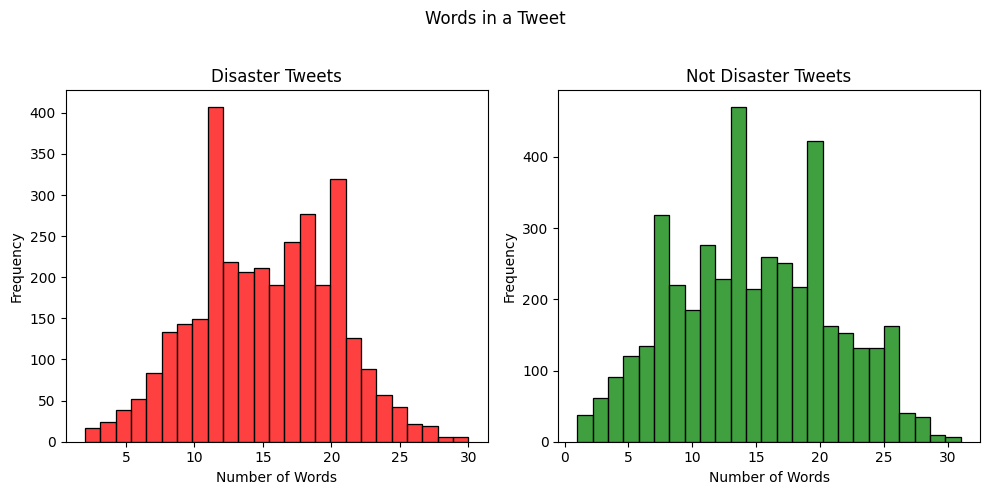

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Number of words in disaster tweets
disaster_tweet_len = df_train[df_train['target'] == 1]['text'].str.split().map(len)
sns.histplot(disaster_tweet_len, bins=25, color='red', ax=ax1)
ax1.set_title('Disaster Tweets')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')

# Number of words in non-disaster tweets
non_disaster_tweet_len = df_train[df_train['target'] == 0]['text'].str.split().map(len)
sns.histplot(non_disaster_tweet_len, bins=25, color='green', ax=ax2)
ax2.set_title('Not Disaster Tweets')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

# Add main title
fig.suptitle('Words in a Tweet')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The distribution of tweet character and word lengths are similar. There is a right skew for character count and most tweets being about 140 characters in length. The distribution for words is about the same with there being between 10-20 words most in most observations. 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


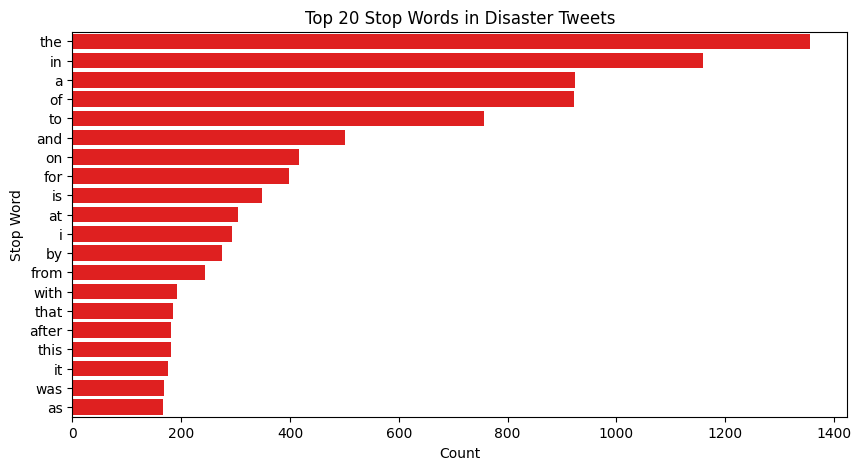

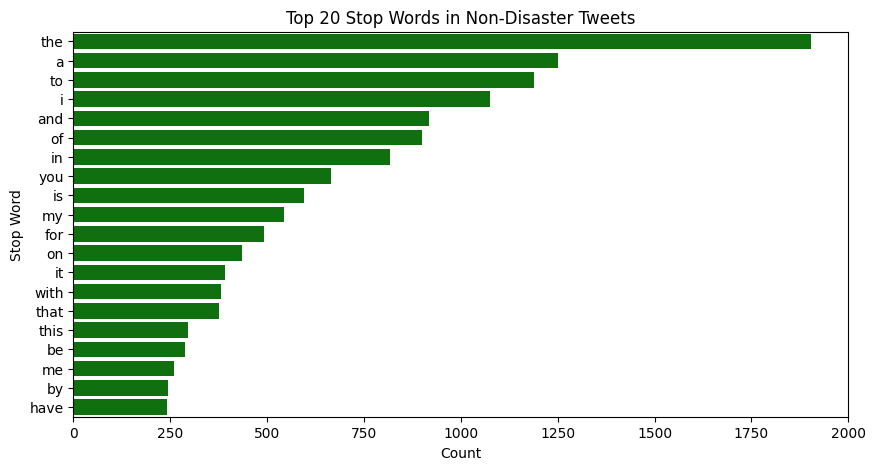

In [11]:
# Ensure nltk stopwords are downloaded
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

df_train['cleaned_text'] = df_train['text'].str.replace('[^\w\s]', '', regex=True).str.lower()

# Tokenize Tweets
df_train['tokenized_text'] = df_train['cleaned_text'].str.split()

# Function to count stop words in a list of words
def count_stop_words(words):
    return sum(1 for word in words if word in stop_words)

# Add a column for stop words count
df_train['stop_words_count'] = df_train['tokenized_text'].map(count_stop_words)

# Separate disaster and non-disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]
non_disaster_tweets = df_train[df_train['target'] == 0]

# Count stop words in both categories
disaster_stop_words = Counter([word for text in disaster_tweets['tokenized_text'] for word in text if word in stop_words])
non_disaster_stop_words = Counter([word for text in non_disaster_tweets['tokenized_text'] for word in text if word in stop_words])

# Convert counters to dataframes for visualization
disaster_stop_words_df = pd.DataFrame(disaster_stop_words.items(), columns=['stop_word', 'count']).sort_values(by='count', ascending=False)
non_disaster_stop_words_df = pd.DataFrame(non_disaster_stop_words.items(), columns=['stop_word', 'count']).sort_values(by='count', ascending=False)

# Plot the top 20 stop words for disaster tweets
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='stop_word', data=disaster_stop_words_df.head(20), color='red')
plt.title('Top 20 Stop Words in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()

# Plot the top 20 stop words for non-disaster tweets
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='stop_word', data=non_disaster_stop_words_df.head(20), color='green')
plt.title('Top 20 Stop Words in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()

The stop words are similar for both and during the cleaning and training step it will be evaluated whether these should be removed or not. 

In [12]:
# Analyze the distribution of keywords
print("\nKeyword counts (including NaN):")
keyword_counts = df_train['keyword'].value_counts(dropna=False)
print(keyword_counts)

# Analyze the distribution of locations
print("\nLocation counts (including NaN):")
location_counts = df_train['location'].value_counts(dropna=False)
print(location_counts)


Keyword counts (including NaN):
keyword
NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

Location counts (including NaN):
location
NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64


The fact the highest category for both of these is NAN would be concerning but since these columns will not be used during the training, no action will be taken to address this isse. 


DataFrame with hashtags information:
                                                   text  num_hashtags  \
0     Our Deeds are the Reason of this #earthquake M...             1   
1                Forest fire near La Ronge Sask. Canada             0   
2     All residents asked to 'shelter in place' are ...             0   
3     13,000 people receive #wildfires evacuation or...             1   
4     Just got sent this photo from Ruby #Alaska as ...             2   
...                                                 ...           ...   
7608  Two giant cranes holding a bridge collapse int...             0   
7609  @aria_ahrary @TheTawniest The out of control w...             0   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...             0   
7611  Police investigating after an e-bike collided ...             0   
7612  The Latest: More Homes Razed by Northern Calif...             0   

                   hashtags  
0             [#earthquake]  
1                        

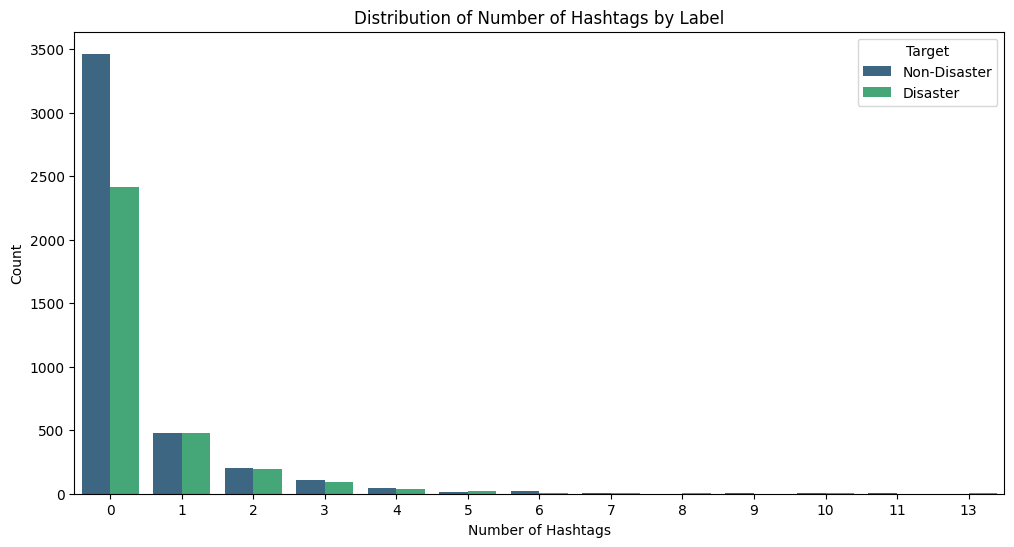

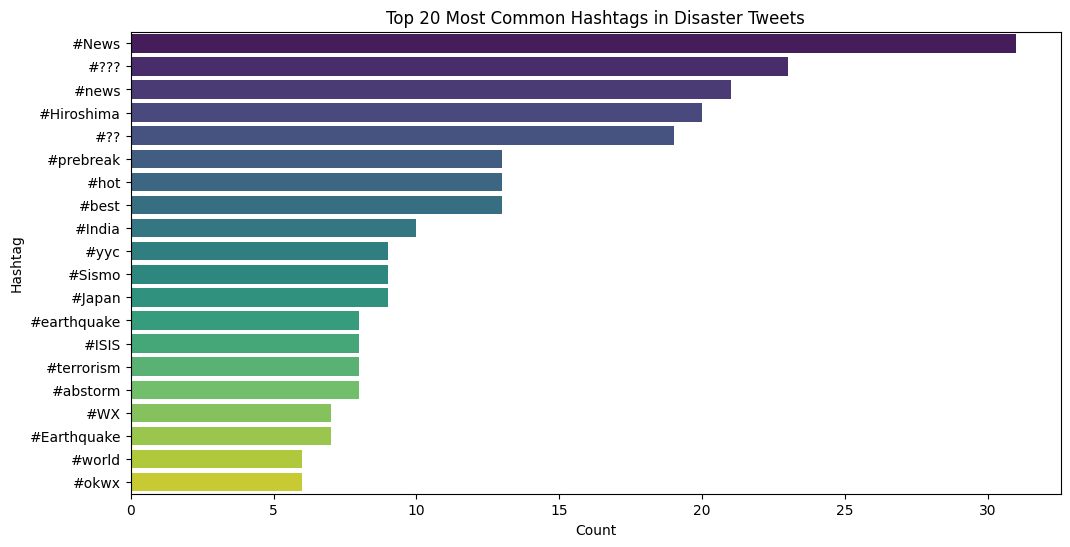

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


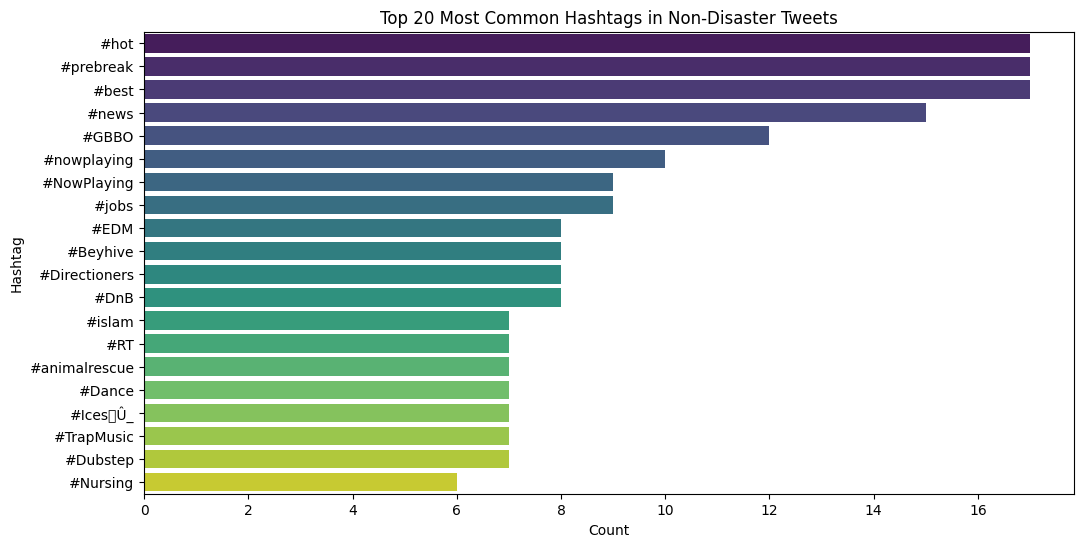

In [13]:
# Function to count hashtags in a tweet
def hash_count(string):
    words = string.split()
    hashtags = [word for word in words if word.startswith('#')]
    return len(hashtags)

# Add a column for the number of hashtags
df_train['num_hashtags'] = df_train['text'].apply(hash_count)

# Add a column for the list of hashtags
df_train['hashtags'] = df_train['text'].apply(lambda x: [word for word in x.split() if word.startswith("#")])

# Inspect the new columns
print("\nDataFrame with hashtags information:")
print(df_train[['text', 'num_hashtags', 'hashtags']])

# Analyze the distribution of the number of hashtags by label
plt.figure(figsize=(12, 6))
sns.countplot(x='num_hashtags', hue='target', data=df_train, palette='viridis')
plt.title('Distribution of Number of Hashtags by Label')
plt.xlabel('Number of Hashtags')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()

# Analyze the most common hashtags by label
disaster_hashtags = [hashtag for hashtags in df_train[df_train['target'] == 1]['hashtags'] for hashtag in hashtags]
non_disaster_hashtags = [hashtag for hashtags in df_train[df_train['target'] == 0]['hashtags'] for hashtag in hashtags]

disaster_hashtag_counts = Counter(disaster_hashtags)
non_disaster_hashtag_counts = Counter(non_disaster_hashtags)

disaster_hashtag_df = pd.DataFrame(disaster_hashtag_counts.items(), columns=['hashtag', 'count']).sort_values(by='count', ascending=False)
non_disaster_hashtag_df = pd.DataFrame(non_disaster_hashtag_counts.items(), columns=['hashtag', 'count']).sort_values(by='count', ascending=False)

# Plot the most common hashtags for disaster tweets
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='hashtag', data=disaster_hashtag_df.head(20), palette='viridis')
plt.title('Top 20 Most Common Hashtags in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.show()

# Plot the most common hashtags for non-disaster tweets
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='hashtag', data=non_disaster_hashtag_df.head(20), palette='viridis')
plt.title('Top 20 Most Common Hashtags in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.show()


Most tweets has no hashtags which was surprising to see, I do not frequent twitter though. When reviewing some articles on NLP of Tweets, many mention had hashtags can be important into classifying a tweet so they will remain where they are. 


DataFrame with emoji information:
                                                   text  num_emojis
0     Our Deeds are the Reason of this #earthquake M...           0
1                Forest fire near La Ronge Sask. Canada           0
2     All residents asked to 'shelter in place' are ...           0
3     13,000 people receive #wildfires evacuation or...           0
4     Just got sent this photo from Ruby #Alaska as ...           0
...                                                 ...         ...
7608  Two giant cranes holding a bridge collapse int...           0
7609  @aria_ahrary @TheTawniest The out of control w...           0
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...           0
7611  Police investigating after an e-bike collided ...           0
7612  The Latest: More Homes Razed by Northern Calif...           0

[7613 rows x 2 columns]


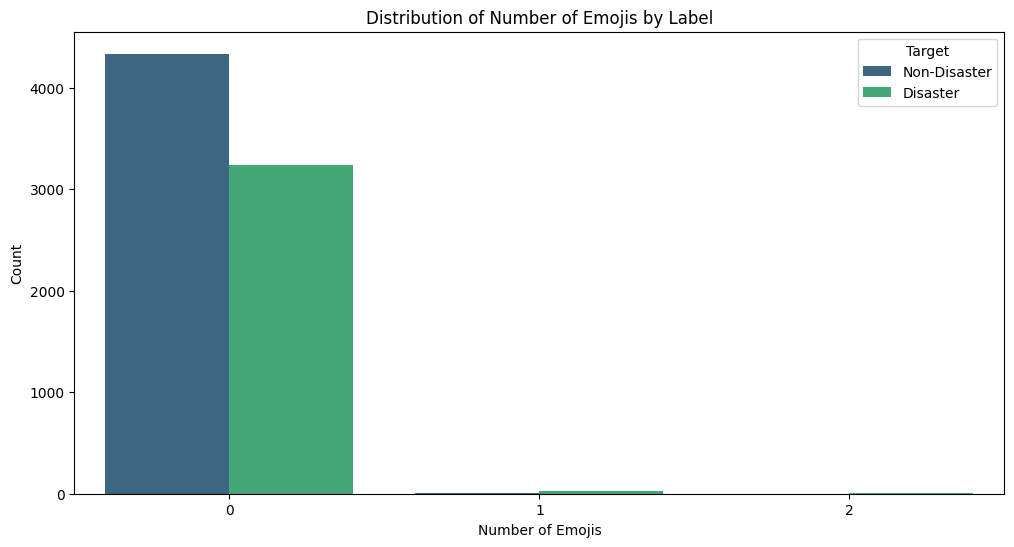

In [14]:
# Function to count emojis in a tweet
def emoji_count(tweet):
    # Convert emojis to text (e.g., 😊 to :smiling_face_with_smiling_eyes:)
    demojized_tweet = emoji.demojize(tweet)
    # Define a pattern to find all the demojized emoji descriptions
    pattern = r':\w+:'
    # Find all matches of the pattern in the demojized tweet
    return len(re.findall(pattern, demojized_tweet))

# Add a column for the number of emojis
df_train['num_emojis'] = df_train['text'].apply(emoji_count)

# Inspect the new column
print("\nDataFrame with emoji information:")
print(df_train[['text', 'num_emojis']])

# Analyze the distribution of the number of emojis by label
plt.figure(figsize=(12, 6))
sns.countplot(x='num_emojis', hue='target', data=df_train, palette='viridis')
plt.title('Distribution of Number of Emojis by Label')
plt.xlabel('Number of Emojis')
plt.ylabel('Count')
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()


The same logic for hashtags will apply to emojis. 

### Cleaning

For cleaning, I will include a function to remove stopwords, punctuation, expand contractions, lowercase all the text so identical words are treated the same and finally tokenize the text.

In [22]:
pip install spacy


In [15]:
pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import nltk
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [17]:
# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the text column
df_train['text_clean'] = df_train['text'].apply(remove_stop_words)

# Inspect the new column
print("\nDataFrame with stop words removed:")
print(df_train[['text', 'text_clean']])



DataFrame with stop words removed:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                             text_clean  
0         Deeds Reason #earthquake May ALLAH Forgive us  
1                Forest fire near La Ronge Sask. Canada  
2     residents asked 'shelter place' notified offic...  
3     13,000 people rec

In [18]:
# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply the function to the text column without stop words
df_train['text_clean'] = df_train['text_clean'].apply(remove_punctuation)

# Inspect the new column
print("\nDataFrame with punctuation removed:")
print(df_train[['text', 'text_clean']])



DataFrame with punctuation removed:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                             text_clean  
0          Deeds Reason earthquake May ALLAH Forgive us  
1                 Forest fire near La Ronge Sask Canada  
2     residents asked shelter place notified officer...  
3     13000 people rec

In [19]:
# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Apply the function to the original text column
df_train['text_clean'] = df_train['text_clean'].apply(expand_contractions)

# Inspect the new column
print("\nDataFrame with expanded contractions:")
print(df_train[['text', 'text_clean']])



DataFrame with expanded contractions:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                             text_clean  
0          Deeds Reason earthquake May ALLAH Forgive us  
1                 Forest fire near La Ronge Sask Canada  
2     residents asked shelter place notified officer...  
3     13000 people r

In [20]:
# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Apply the function to the expanded text column
df_train['text_clean'] = df_train['text_clean'].apply(lowercase_text)

# Inspect the new column
print("\nDataFrame with lowercased text:")
print(df_train[['text', 'text_clean']])



DataFrame with lowercased text:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                             text_clean  
0          deeds reason earthquake may allah forgive us  
1                 forest fire near la ronge sask canada  
2     residents asked shelter place notified officer...  
3     13000 people receive

In [21]:
# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to the text column without punctuation
df_train['tokens'] = df_train['text_clean'].apply(tokenize_text)

# Inspect the new column
print("\nDataFrame with tokenized text:")
print(df_train[['text', 'text_clean', 'tokens']])



DataFrame with tokenized text:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                             text_clean  \
0          deeds reason earthquake may allah forgive us   
1                 forest fire near la ronge sask canada   
2     residents asked shelter place notified officer...   
3     13000 people rece

In [23]:
# Ensure necessary NLTK data is downloaded
nltk.download('punkt')

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# Ensure 'tokens' and 'target' columns are in the dataframe
if 'tokens' not in df_train.columns or 'target' not in df_train.columns:
    raise ValueError("DataFrame must contain 'tokens' and 'target' columns.")

# Function for lemmatization
def lemmatize_text(tokens):
    text = " ".join(tokens)  # Join tokens back into a single string
    doc = nlp(text)  # Process the text with SpaCy
    lemmatized_tokens = [token.lemma_ for token in doc]  # Lemmatize tokens
    return lemmatized_tokens

# Apply lemmatization to the tokenized text column
df_train['lemmatized_tokens'] = df_train['tokens'].apply(lemmatize_text)

# Combine lemmatized tokens back into a single string for tokenizer input
df_train['tokenized_text'] = df_train['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Inspect the new columns
print("\nDataFrame with tokenized and lemmatized text:")
print(df_train[['text', 'tokens', 'lemmatized_tokens', 'tokenized_text']])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

DataFrame with tokenized and lemmatized text:
                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                                 tokens  \
0     [deeds, reason, earthquake, may, allah, forgiv...   
1         

With the cleaning complete, we will move on to modeling. 

### Modeling

The first model attempted to be trained on will be an LSTM model. This model is useful for training for data invovling sequential data, like a tweet, and are designed to remember long term dependencies. They are frequently used in sentiment analysis which is the essence of what we are trying to do here. 

The second model trained for comparison will be a GRU which is also used for sequential data which are similar to LSTMs but are simpler and computationally effcient compared to a LSTM. 

#### Training the LSTM

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5804 - loss: 0.6739 - val_accuracy: 0.7682 - val_loss: 0.5528
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7884 - loss: 0.5051 - val_accuracy: 0.7951 - val_loss: 0.4458
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8447 - loss: 0.3714 - val_accuracy: 0.8030 - val_loss: 0.4492
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8710 - loss: 0.3073 - val_accuracy: 0.7965 - val_loss: 0.4644
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8897 - loss: 0.2787 - val_accuracy: 0.7899 - val_loss: 0.4916
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.80      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

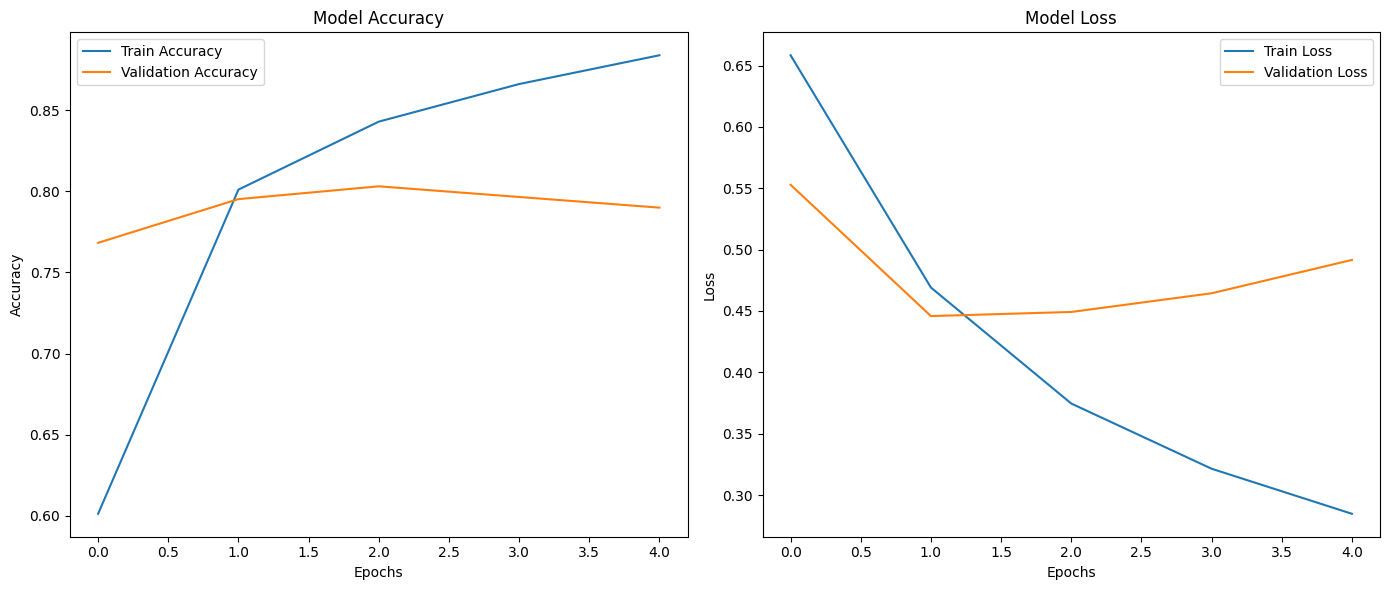

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train['tokenized_text'], df_train['target'], test_size=0.2, random_state=42)

# Tokenizer should fit on the tokenized text
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_seq_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(75, activation='relu', dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1, callbacks=[early_stopping])

# Evaluate the model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


This model does not perform well where we see significant overfitting in the validation lines. It is possible the data is not cleaned sufficently another underlying problem preventing the model from generalizing well. 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5578 - loss: 0.6825 - val_accuracy: 0.6921 - val_loss: 0.6654
Epoch 2/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7135 - loss: 0.6014 - val_accuracy: 0.7505 - val_loss: 0.5543
Epoch 3/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8331 - loss: 0.4010 - val_accuracy: 0.7531 - val_loss: 0.5216
Epoch 4/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8526 - loss: 0.3580 - val_accuracy: 0.7636 - val_loss: 0.5080
Epoch 5/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8754 - loss: 0.3000 - val_accuracy: 0.7479 - val_loss: 0.5167
Epoch 6/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8890 - loss: 0.2688 - val_accuracy: 0.7439 - val_loss: 0.5340
Epoch 7/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9015 - loss: 0.2578 - val_accuracy: 0.7367 - val_loss: 0.5416
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0    

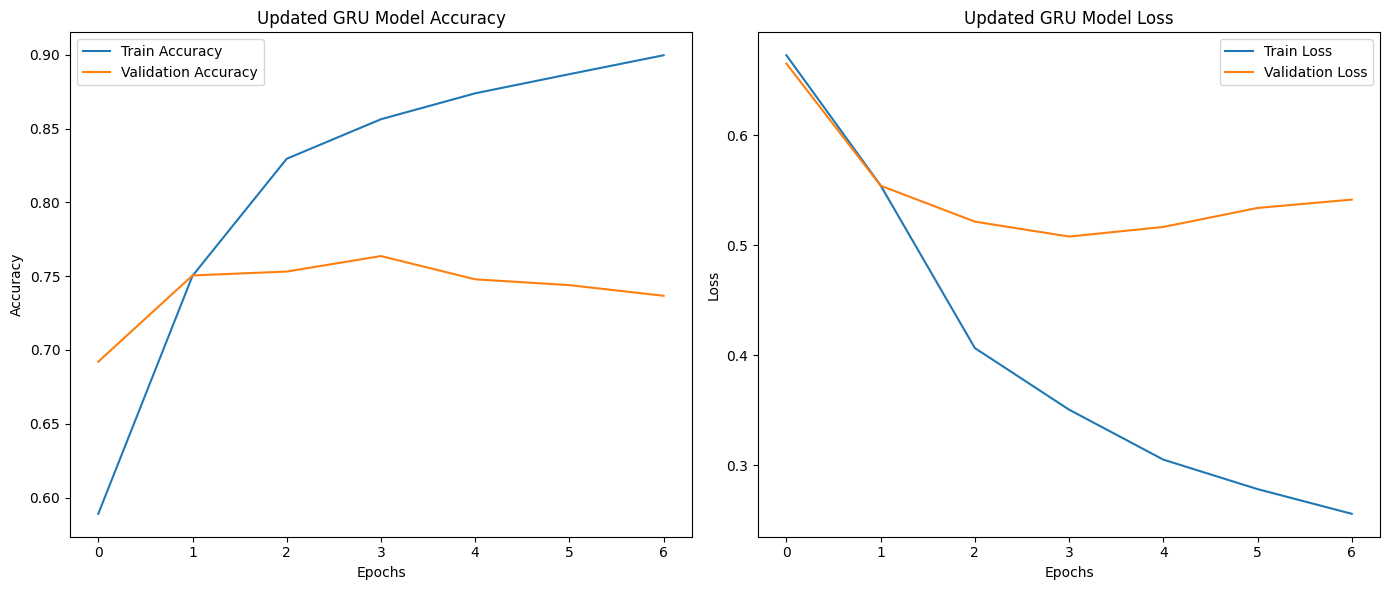

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train['tokenized_text'], df_train['target'], test_size=0.2, random_state=42)

# Tokenizer should fit on the tokenized text
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_seq_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Define the updated GRU model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=5000, output_dim=100, input_length=max_seq_length))
model_gru.add(SpatialDropout1D(0.4))  # Increased dropout rate for regularization
model_gru.add(GRU(100, dropout=0.5, recurrent_dropout=0.4))  
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_gru.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the updated GRU model
history_gru = model_gru.fit(X_train_padded, y_train, epochs=12, batch_size=128, validation_data=(X_test_padded, y_test), verbose=1, callbacks=[early_stopping])

# Evaluate the updated GRU model
y_pred_gru = (model_gru.predict(X_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_gru))

# Plot accuracy and loss for the updated GRU model
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Updated GRU Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Updated GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The GRU model utilizes a sigmoid activation function, ADAM as an optimizer and drop out to help with regularization. 

The GRU performs marginally better but not satisfactory in my opinion. Due to time restrictions, I have decided to implement this model for my submission but discuss future work below and plan to return to this when possible. If I see a significant improvement, I plan to resubmit and discuss my findings. 

### Testing and Sumission

In [34]:
test_df = pd.read_csv(r"/kaggle/input/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [35]:
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df.head()

,id
0,0
1,2
2,3
3,9
4,11


In [36]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define preprocessing functions
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def expand_contractions(text):
    return contractions.fix(text)

def tokenize_text(text):
    return word_tokenize(text)

def lemmatize_text(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc]

def preprocess_text(text):
    text = remove_punctuation(text)
    text = expand_contractions(text)
    text = text.lower()
    tokens = tokenize_text(text)
    lemmatized_tokens = lemmatize_text(tokens)
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to the test data
df_test['text_clean'] = df_test['text'].apply(preprocess_text)

# Tokenize the cleaned text
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(df_train['tokenized_text'])  # Fit on training data

df_test['tokenized_text'] = tokenizer.texts_to_sequences(df_test['text_clean'])

# Pad the sequences
max_seq_length = max(len(seq) for seq in df_train['tokenized_text'])
X_test_padded = pad_sequences(df_test['tokenized_text'], maxlen=max_seq_length)


In [37]:
# Assuming model_gru is already trained
# model_gru = tf.keras.models.load_model('path_to_your_trained_model.h5')  # Uncomment if needed

# Make predictions
y_pred_test = (model_gru.predict(X_test_padded) > 0.5).astype("int32")

# Prepare the submission DataFrame
submission_df = pd.DataFrame()
submission_df['id'] = df_test['id']
submission_df['target'] = y_pred_test

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission DataFrame
print(submission_df.head())


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
   id  target
0   0       1
1   2       0
2   3       0
3   9       1
4  11       0


In [38]:
# Save the submission DataFrame to a CSV file
submission_path = '/kaggle/working/submission.csv'
submission_df.to_csv(submission_path, index=False)

# Display the first few rows of the submission DataFrame
print(submission_df.head())

   id  target
0   0       1
1   2       0
2   3       0
3   9       1
4  11       0


# Conclusion and Future Work

The submission achieved an accuracy score of .51 which is not acceptable for any resonable use case. I have already spent more time reading into how to implement an LSTM and it is possible I am not initiating the data correctly which could be the source of my problem. As I learn more, I plan to review other sources where LSTMs were implemented and see if my error is occuring there. I believe my cleaning is sufficent to allow decent generalization to the data. When I say decent, I would expect to see an accuracy score of greater than 80% and do not believe that to be that difficult to achieve. 

For this reason, future work will include updating my code to ensure I am intializing the training properly. Additonally, I would review cleaning techniques on this data to determine if I have any errors that could be contributed to low accuracy. It is possible more research needs to go into whether or not hashtags and emojis should be included or not. 

With this said, the notebook does perform EDA, clean and train two models on a dataset with the goal to predict a label of positive or negative. While it does do this, there is room for improvement and I plan to return to this in the future to attempt improvement. 